# Transfer learning

Using of pre trained model for solving another task.

Learning from scratch is not always the best option.

CNNs usually takes a lot of time to train.

Lots of tasks are transferable to different problem domain - lower parts of CNN are learning general patterns applicable on wide range of tasks.

In the end it is not that different to for example clasify between dogs/cats and cows/horses.

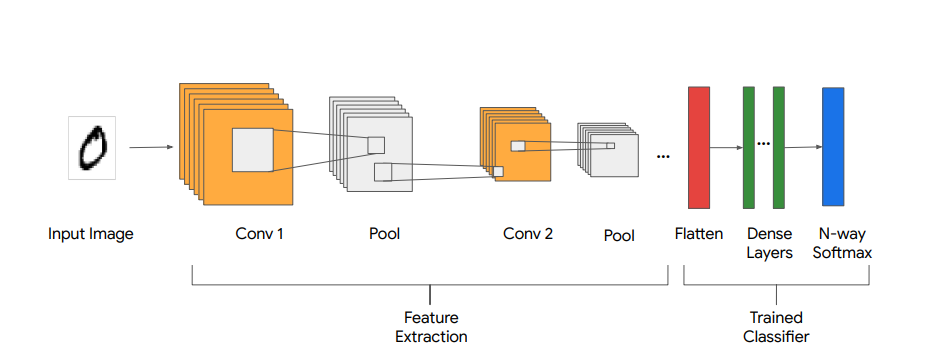

Advantages of transfer learing:
* **Saves the time** - you don't need to train long as you would need to if you would train whole network from scratch
* **Saves the resources** - very deep neural networks are resource expensive to train
* **You don't need that much of a data** - you need just fine tune trained weighths a little to fit on your data (instead of set them from random values)

You can:
* Use the whole architecture and fine-tune to your set of data - usually with optimizer with lower learning rate
* Take just a part of a neural network (ony CNN layers of ResNet and omitt the classification dense layers on top) for feature vector extraction
* Use whole network as with frozen layers
* Train only few of the top layers to fit your problem

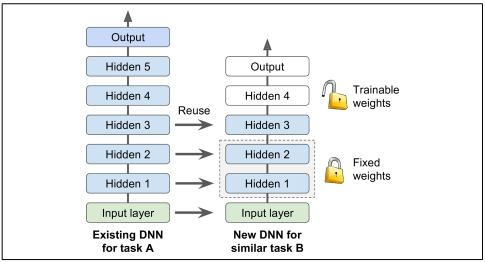

## Using Keras.Applications

https://keras.io/api/applications/

The easiest way.

You only need to import TensorFlow to be able to use pre-trained models.

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

We could use CIFAR-10 for demonstration.

In [ ]:
(training_images, training_labels), (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_images[i])
    plt.xlabel(class_names[training_labels[i][0]])
plt.show()

### Setting up the ResNet50 from Keras
Use ResNet50 with imagenet data.

https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

**Arguments:**
* **include_top**: whether to include the fully-connected layer at the top of the network.
* **weights**: one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.
* **input_shape**: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with 'channels_last' data format) or (3, 224, 224) (with 'channels_first' data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.
* **pooling**: Optional pooling mode for feature extraction when include_top is False.
    * **None** means that the output of the model will be the 4D tensor output of the last convolutional block.
    * **avg** means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.
    * **max** means that global max pooling will be applied.
* **classes**: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.

In [ ]:
resnet = tf.keras.applications.resnet.ResNet50(
    # use original ResNet input configuration
    input_shape=(224, 224, 3),
    # we want to use model for feature extraction, not to retrain it
    include_top=False,
    # use global average pooling for flattening the output
    pooling='avg',
    # use pretrained weights for ImageNet
    weights='imagenet')

And since we don't want to re-train ResNet in this case (we can, it is called *Fine tuning*), we will freeze its layers by setting *trainable=False*.

Be aware that it is good to set lower learning rate when allowing re-training the model. 

If we are using model just for feature extraction and add randomly initialized layers on the top, the big gradient corrections could have negative influence on already pre-trained weights of model.

In [ ]:
resnet.trainable = False

### Preprocessing images

Each model requires specific image processing for correct prediction (for example normalizing values, switching channel order, etc...).

Models from Keras Applications comes up with implemented preprocessing for us.

You can find the correct method in documentation, for ResNet50 it is:

https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input

In [ ]:
def preprocess_image_input(input_images):
    # we just need to take a batch of images and apply the preprocessing on them
    output_images = tf.keras.applications.resnet50.preprocess_input(input_images)
    return output_images

Call the method on CIFAR-10 images.

In [ ]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

### Setting up the CIFAR-10 classification model

ResNet expects (224, 224, 3) inputs shape, but CIFAR-10 only images with (32, 32, 3) shape. 

We could resize the images in preprocessing function or we can just use upsampling layer in Keras that upsample images by set factor.

Using the layer could be advantegous because we will not need to resize images for predictions.

In [ ]:
# set the input by CIFAR-10 shapes - 32, 32, 3
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
# resize by factor of 7 -> 7 * 32 = 224
resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
# get features vectors from ResNet
extracted_features = resnet(resize)
# set up our layers for image classification
x = tf.keras.layers.Dense(1024, activation="relu")(extracted_features)
x = tf.keras.layers.Dense(512, activation="relu")(x)
# CIFAR-10 contains only images of 10 classes, so we will use 10 neurons and softmax activation
classification_output = tf.keras.layers.Dense(10, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs = classification_output)

Compile the model.

In [ ]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy'])

We can see in the summary the model have 26.2M of parameters, however, we need to train only 2.6M of them, the rest are frozen ResNet50 layers parameters.

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Training

It is complicated model, co even 4 epochs took significant time on my laptop, so I saved the model and I will not train it here in real time.

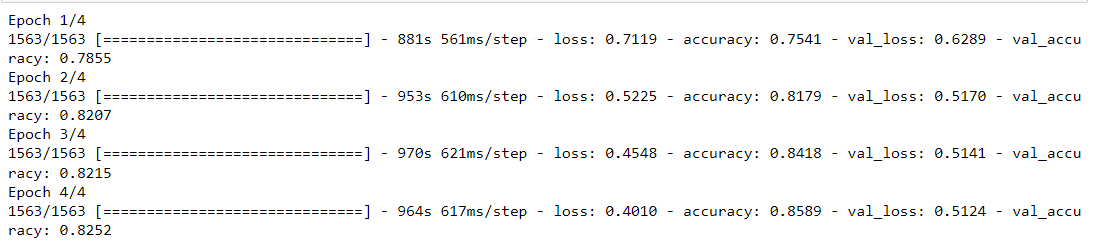

In [ ]:
history = model.fit(train_X, training_labels, epochs=4, validation_data = (valid_X, validation_labels), batch_size=32)
model.save('trained_cifar.h5')

### Loss function

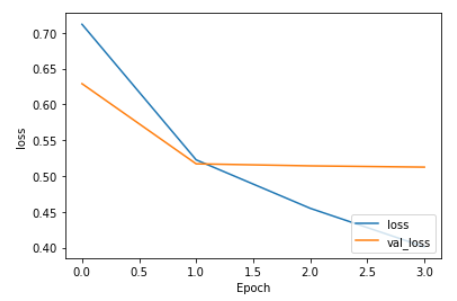

### Accuracy

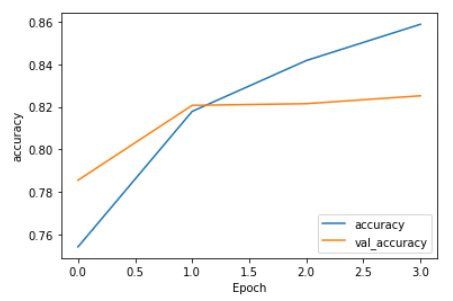

### Evaluation

Model has 82.52% accuracy. 

We could get higher accuracy maybe by fine tune the model (unlocking ResNet feature extractor), but even this is still much better than using arbitrary CNN model trained from scratch.

In [ ]:
%%time
trained_model = tf.keras.models.load_model('trained_cifar.h5')
validation_result = trained_model.evaluate(valid_X, validation_labels)
print(f'accuracy: {validation_result[1]*100:.2f}%')

### Prediction

Making predictions with trained model.

In [ ]:
# image index in validation set
IMAGE_INDEX = 7

In [ ]:
%%time
# make a prediction and get the label with the highest confidence
class_names[np.argmax(trained_model.predict(np.expand_dims(valid_X[IMAGE_INDEX], axis=0)))]

Plot results.

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(validation_images[IMAGE_INDEX])
plt.xlabel(class_names[validation_labels[IMAGE_INDEX][0]])
plt.show()

## Partial fine tuning of ResNet

If we would like to re-train model, we don't need to train all layers. 

We could pick and train only a last few residual blocks and leave lower layers (extracting low level features) as they are.

In [ ]:
feature_extractor = tf.keras.applications.resnet.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='avg',
    weights='imagenet')

Look at model structure.

In [ ]:
tf.keras.utils.plot_model(feature_extractor, show_shapes=True)

We are able to iterate over model layers.

In [ ]:
for layer in feature_extractor.layers:
    print(layer.name)

We can choose to train only the last few residual blocks.

It is possible to start from layer *conv5_block1_out*.

In [ ]:
trainable = False
for layer in feature_extractor.layers:
    # set layers to trainable from layer with the set name to the end
    if layer.name == "conv5_block1_out":
        trainable = True
    # you can se trainable not just to the whole model, but also for individual layer
    layer.trainable = trainable

Now we can just use feature extractor and plug it in to the layers for further processing.

In this case we are trying to get another feature vector of 256 components.

In [ ]:
dense1 = tf.keras.layers.Dense(512, activation="relu")(feature_extractor.output)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(256, activation="relu")(dense1)
dense2 = tf.keras.layers.BatchNormalization()(dense2)
output = tf.keras.layers.Dense(256)(dense2)
embedding = tf.keras.Model(feature_extractor.input, output)

If we change different layers to train, we will see different numbers in *Trainable params*.

In [ ]:
embedding.summary()

## TensorHub

Much bigger repository of trained models possible to use for predictions or feature extraction. 

You just need to instal *tensorflow-hub* package using conda or pip.

You can find available models on https://www.tensorflow.org/hub 

To use them it is just enough to put model URL to special type of layer - *tensorflow_hub.KerasLayer*.

### Use ResNet50 trained on ImageNet-21k from TensorFlow Hub

As an example, we can use ResNet50 trained on ImageNet-21k - dataset consisting of 14 197 122 images, each tagged in a single-label fashion by one of 21 841 classes:

https://tfhub.dev/google/bit/m-r50x1/imagenet21k_classification/1

Disadvantage of these models is they supposed to be used like black boxes - you cannot choose what part of model you want to train. You can just set training for the whole model.

Sometimes it could be difficult to find what kind of preprocessing model needs and usually you need to do it yourself.

You should usually use common image processing if nothing specified:

https://www.tensorflow.org/hub/common_signatures/images#input

In [ ]:
# we just need to import tensorflow_hub
import tensorflow_hub as hub
import cv2
# import csv module for loading ImageNet-21k labels
import csv

### Setting up the model and preprocessing
And use the model by putting URL to KerasLayer.

In [ ]:
module = hub.KerasLayer('https://tfhub.dev/google/bit/m-r50x1/imagenet21k_classification/1')

Load labels for ImageNet-21k.

In [ ]:
labels_file = 'https://storage.googleapis.com/bit_models/imagenet21k_wordnet_lemmas.txt'
#download labels and creates a maps
downloaded_file = tf.keras.utils.get_file('labels.txt', origin=labels_file, cache_dir='.')
# load labels to list
with open(downloaded_file, newline='') as f:
    reader = csv.reader(f)
    labels = list(reader)

In [ ]:
labels

### Making a prediction

In [ ]:
def local_image(filename):
    # read the image file in RGB
    image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    # ResNet operates on 224,224
    image = cv2.resize(image, (224,224), interpolation = cv2.INTER_NEAREST)
    # reshape into shape [batch_size, height, width, num_channels]
    img_reshaped = np.expand_dims(image, axis=0)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
    return image

In [ ]:
test_image = local_image('transfer_learning_images/kocour.jpg')

In [ ]:
prediction = module(test_image)
# model returns only logits, so for probabilities we need to run it through activation function
probabilities =  tf.nn.sigmoid(prediction)

Get top 5 predictions.

In [ ]:
top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()

Plot results.

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(np.squeeze(test_image))
plt.show()
for i in top_5:
    print(f'probability {probabilities[0, i]}, labels: {labels[i]}')

## Tensorflow Hub transfer learning

For transfer learning we want to find ResNet only predicting feature vectors:

https://tfhub.dev/google/bit/m-r50x1/1

In [ ]:
def preprocess_image_input(input_images):
    # I need to normalize image, be aware the dataset typed to float consumes much more memory.
    output_images = input_images/255.0
    return output_images

In [ ]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

We can use feature extractor from TF Hub like a regular layer.

In [ ]:
hub_extractor = hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", trainable = False)

inputs = tf.keras.layers.Input(shape=(32,32,3))
resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
extracted_features = hub_extractor(resize)
x = tf.keras.layers.Dense(1024, activation="relu")(extracted_features)
x = tf.keras.layers.Dense(512, activation="relu")(x)
# CIFAR-10 contains only images of 10 classes, so we will use 10 neurons and softmax activation
classification_output = tf.keras.layers.Dense(10, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs = classification_output)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs = classification_output)
model.compile(optimizer='adam', 
            loss='sparse_categorical_crossentropy',
            metrics = ['accuracy'])

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
EPOCHS = 4
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=32)

In [ ]:
model.save('trained_hub.h5')

Because KerasLayer is custom object, we need to specify it during de-serialization.

In [ ]:
trained_model = tf.keras.models.load_model(('trained_hub.h5'), custom_objects={'KerasLayer':hub.KerasLayer})